In [1]:
import pandas as pd
import os
from typing import Callable

def get_all_results(callback: Callable[[str], pd.DataFrame]) -> pd.DataFrame:
    df = pd.DataFrame()
    for folder in os.listdir('./data'):
        try:
            [model, process, setup] = folder.split('_')
        except:
            # maybe the filesystem added a secret file
            continue
        result = callback(os.path.join('./data', folder))
        result['model'] = model
        result['process'] = process
        result['setup'] = setup
        result['identifier'] = folder
        df = pd.concat([df, result], ignore_index=True)
    return df

In [2]:
import matplotlib.pyplot as plt

def plot_model_comparison(df, title="Model Comparison"):
    """
    Plot a line chart comparing three models across four different setups.

    Parameters:
    df (pd.DataFrame): DataFrame with columns ['GeminiPro', 'Mistral', 'Deepseek']
                      and rows ['Monolithic', 'Duo', 'Manager', 'Team']
    """
    # Create the figure and axis
    plt.figure(figsize=(10, 6))

    # Reindex the dataframe to ensure correct order
    df = df.reindex(["Monolithic", "Duo", "Manager", "Team"])

    # Define colors for each model
    colors = {
        "GeminiPro": "#AB6E96", 
        "Mistral": "#DF7F42",
        "Deepseek": "#536AF5",
    }

    # Plot each model as a separate line
    for model in df.columns:
        plt.plot(
            df.index,
            df[model],
            marker="o",
            linewidth=2,
            markersize=6,
            color=colors[model],
            label=model,
        )

    # Customize the plot
    plt.xlabel("Multi-Agent System", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.title(
        title, fontsize=14, fontweight="bold"
    )
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)

    # Rotate x-axis labels if needed for better readability
    #plt.xticks(rotation=45)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot
    plt.show()

# Average Performance
How many bpmn features could the different models reconstruct?

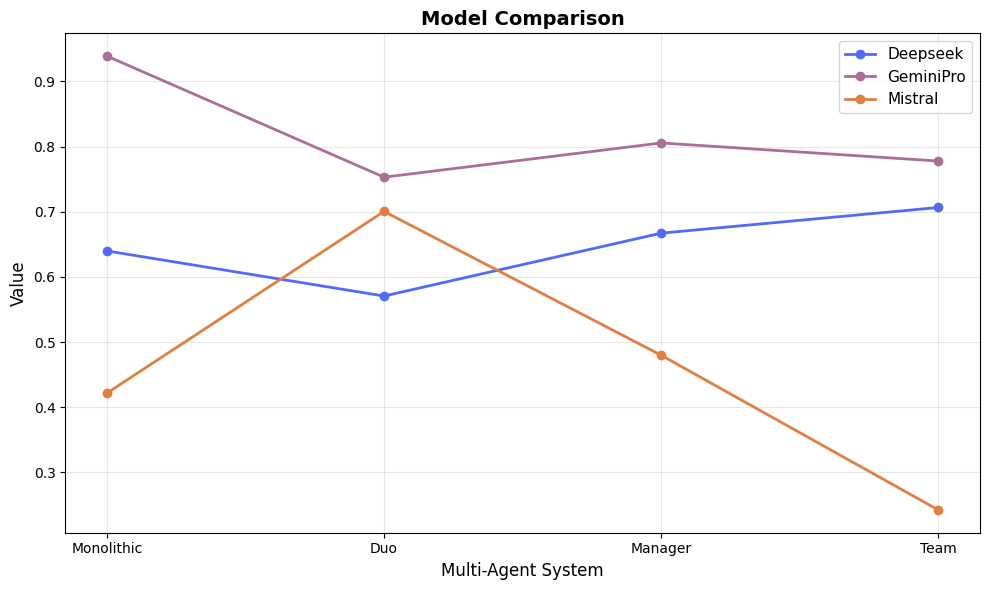

In [3]:
shop_features = pd.read_csv('shop-features.csv', index_col=0, header=[0,1], sep=',') 
hotel_features = pd.read_csv('hotel-features.csv', index_col=0, header=[0,1], sep=',') 
reimbursement_features = pd.read_csv('reimbursement-features.csv', index_col=0, header=[0,1], sep=',') 
features = pd.concat([shop_features.mean(), hotel_features.mean(), reimbursement_features.mean()], axis=1).mean(axis=1)
features = features.reset_index().pivot_table(
    index="level_1",
    columns="level_0",
    values=0,
)

plot_model_comparison(features)

# Token Analysis
In the token analysis one run is filtered out, because the model repeated itself multiple times, generating 72 powl models, which highly skewed the results of the token analysis.

In [4]:
def get_tokens(path: str) -> pd.DataFrame:
    if os.path.basename(path) == 'GeminiPro_Shop_Manager':
        return pd.DataFrame()
    
    invocations = 0
    prompt_tokens = 0
    completion_tokens = 0
    for file in os.listdir(os.path.join(path, 'agents')):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(path, 'agents', file))
            invocations += df["invocation"].max()
            prompt_tokens += df["prompt_tokens"].sum()
            completion_tokens += df["completion_tokens"].sum()
    return pd.DataFrame([[invocations, prompt_tokens, completion_tokens]], columns=["invocations", "prompt_tokens", "completion_tokens"])
tokens_df = get_all_results(get_tokens)
invocations = tokens_df.pivot_table(index="setup", columns="model", values="invocations", aggfunc="mean") 
prompt_tokens = tokens_df.pivot_table(index="setup", columns="model", values="prompt_tokens", aggfunc="mean")
completion_tokens = tokens_df.pivot_table(index="setup", columns="model", values="completion_tokens", aggfunc="mean")

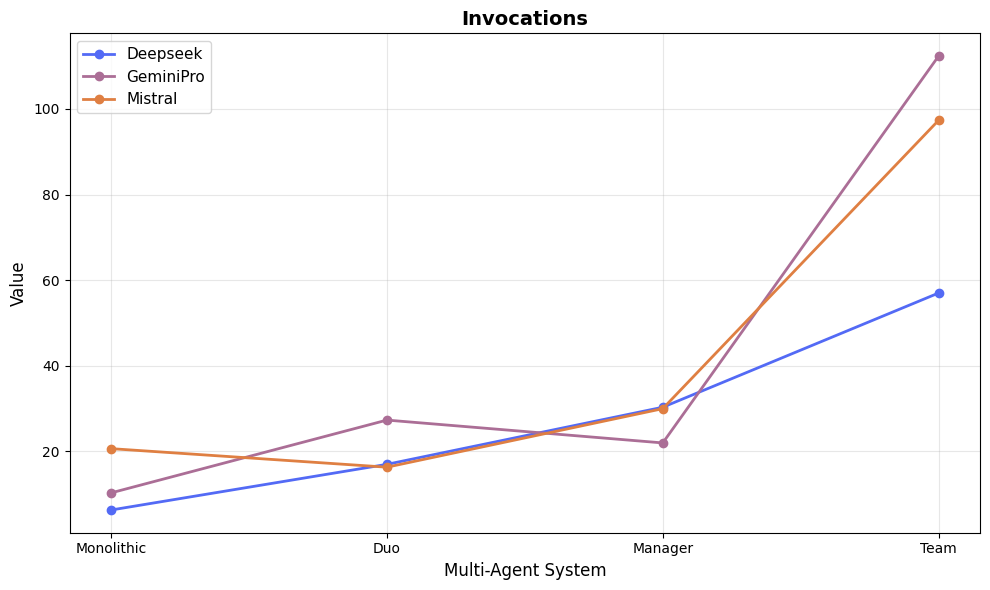

In [5]:
plot_model_comparison(invocations, title="Invocations")

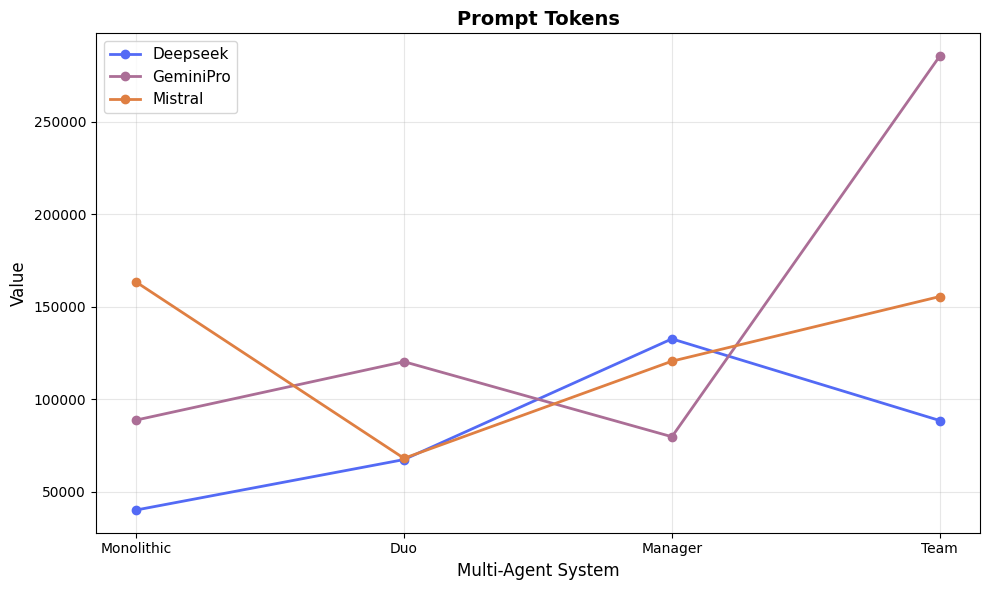

In [6]:
plot_model_comparison(prompt_tokens, title="Prompt Tokens")

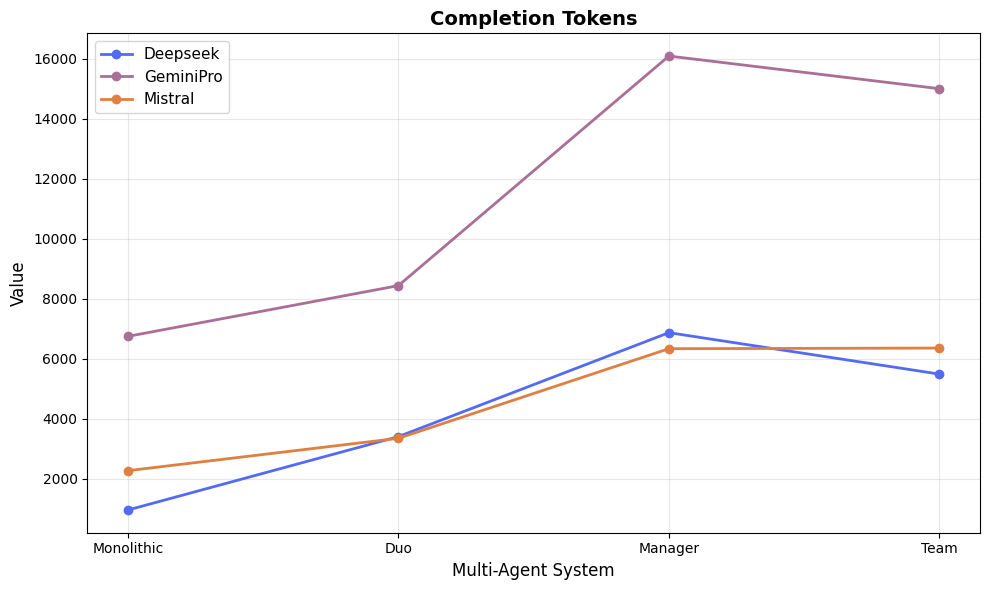

In [7]:
plot_model_comparison(completion_tokens, title="Completion Tokens")

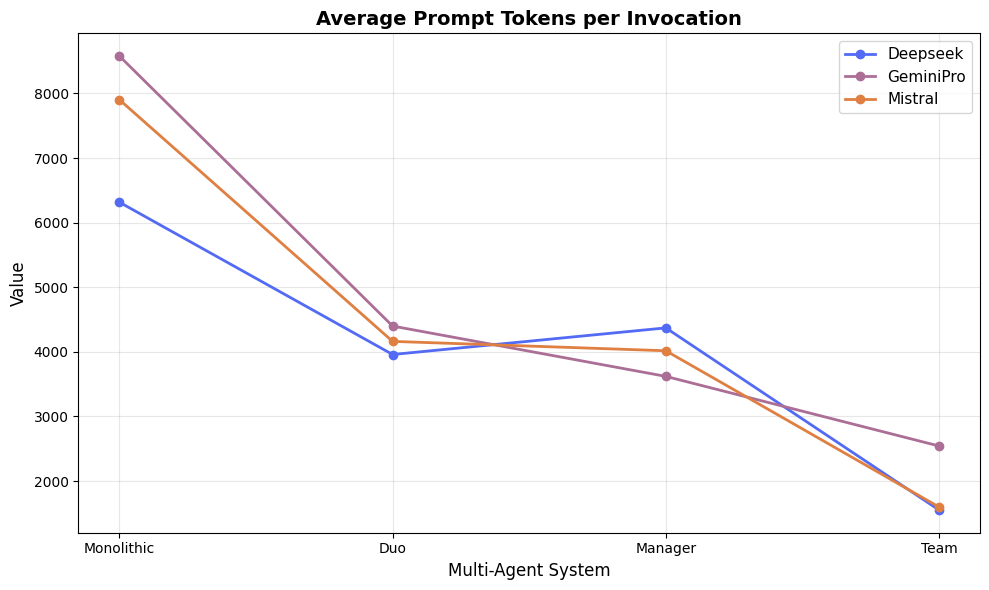

In [8]:
plot_model_comparison(prompt_tokens / invocations, 'Average Prompt Tokens per Invocation')

# Failure Analysis
The failure analysis is based on the paper: "Why Do Multi-Agent LLM Systems Fail?" 

by: Cemri, M., Pan, M. Z., Yang, S., Agrawal, L. A., Chopra, B., Tiwari, R., Keutzer, K., Parameswaran, A., Klein, D., Ramchandran, K., Zaharia, M., Gonzalez, J. E., & Stoica, I. (2025)M 

https://doi.org/10.48550/arXiv.2503.13657



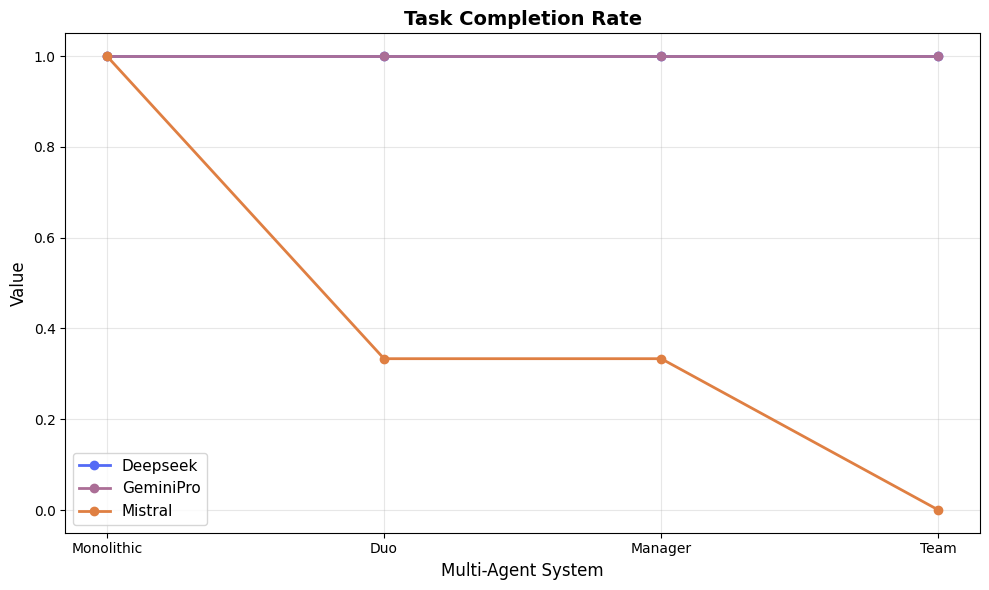

In [9]:
mast = get_all_results(
    lambda path: pd.read_csv(os.path.join(path, "artifacts/mast_results.csv"))
)
mast["manager"] = mast["Agent"].isin(
    ["Manager", "Manager_Interviewer", "Process Consultant"]
)

only_manager = mast[mast["manager"]]
manager_task_completed_rate = only_manager.pivot_table(
    index="setup", columns="model", values="Task_Completed", aggfunc="mean"
)
plot_model_comparison(manager_task_completed_rate, title="Task Completion Rate")

In [10]:
failure_columns = [
    "Disobey_Task_Specification", "Disobey_Role_Specification", "Step_Repetition",
    "Loss_of_Conversation_History", "Unaware_of_Termination_Conditions", "Conversation_Reset",
    "Fail_to_Ask_for_Clarification", "Task_Derailment", "Information_Withholding",
    "Ignored_Other_Agents_Input", "Action_Reasoning_Mismatch", "Premature_Termination",
    "No_or_Incorrect_Verification", "Weak_Verification"
]

In [11]:
def failure_count(path: str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(path, "artifacts/mast_results.csv"))
    total_failures = df[failure_columns].sum(axis=1).sum()
    failure_rate = []
    for file in os.listdir(os.path.join(path, "agents")):
        if file.endswith(".csv"):
            agent_name = file.split('.')[0]
            agent_stats = pd.read_csv(os.path.join(path, "agents", file))
            invocations = agent_stats["invocation"].max()
            agent_failed = df.loc[df["Agent"] == agent_name, failure_columns].any(axis=1).item()
            failure_rate.append(agent_failed / invocations)

    return pd.DataFrame(
        [[total_failures, sum(failure_rate) / len(failure_rate)]],
        columns=["total_failures", "failure_per_invocation"],
    )

failure_counts_df = get_all_results(failure_count)
average_failures = failure_counts_df.pivot_table(
    index="setup", columns="model", values="total_failures", aggfunc="mean"
)
average_failures_per_invocation = failure_counts_df.pivot_table(
    index="setup", columns="model", values="failure_per_invocation", aggfunc="mean"
)

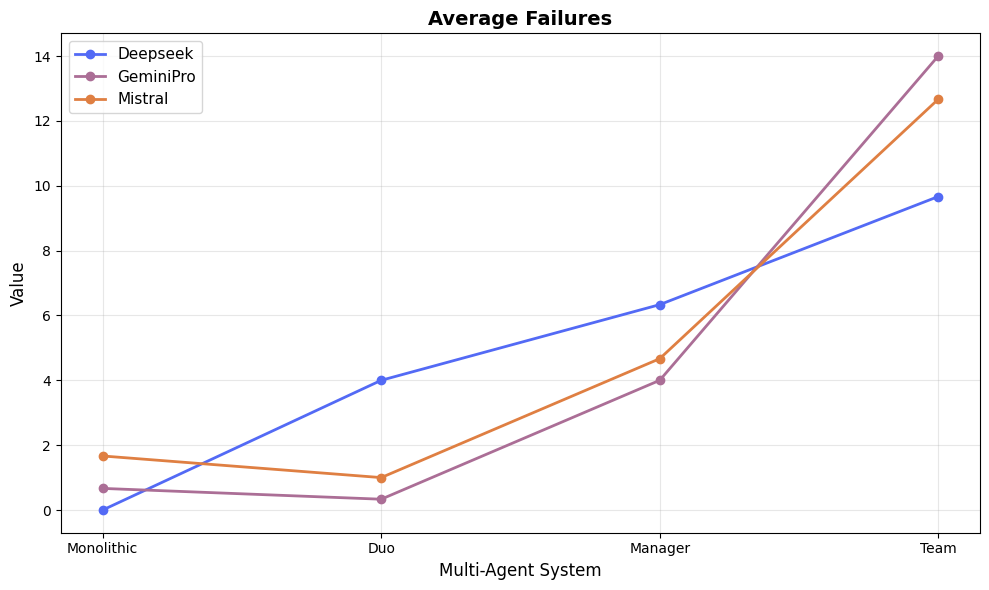

In [12]:
plot_model_comparison(average_failures, title="Average Failures")

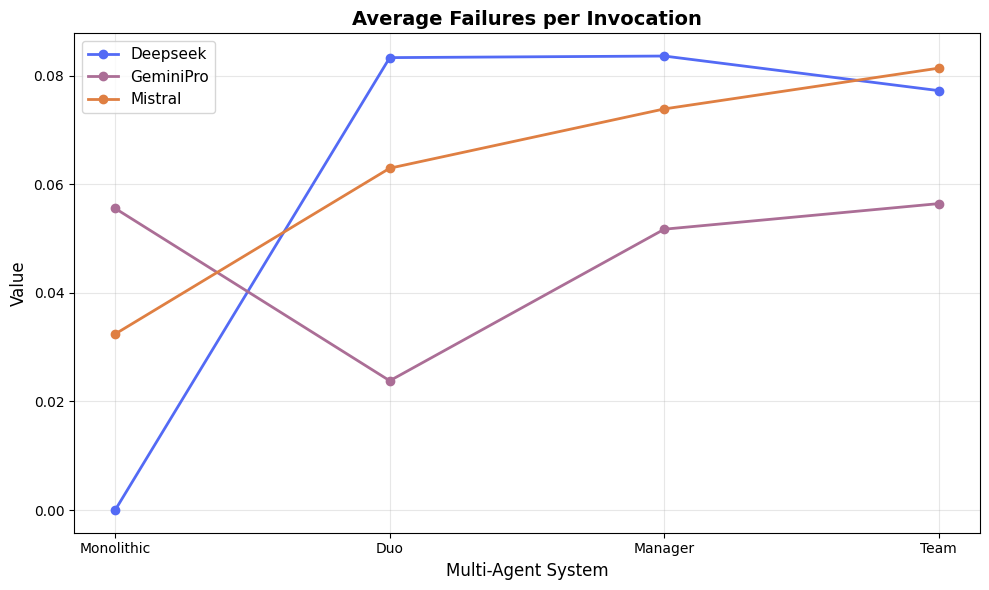

In [13]:
plot_model_comparison(average_failures_per_invocation, title="Average Failures per Invocation")

In [18]:
normalized_mast = mast.copy()
for col in failure_columns:
    normalized_mast[col] = mast[col] / mast[failure_columns].sum(axis=1)
normalized_mast.fillna(0, inplace=True)

In [19]:
grouped_mast = (
    normalized_mast.groupby(["model", "process", "setup"])
    .agg({**{col: "mean" for col in failure_columns}})
    .reset_index()
)
failures = grouped_mast.groupby(["setup"]).agg(
    {**{col: "mean" for col in failure_columns}}
).T
for col in failures.columns:
    failures[col] = failures[col] / failures[col].sum()

Here the benchmark data from the paper are added.

In [20]:
MAST_PAPER = [0.1098, 0.005, 0.1714, 0.0333, 0.0982, 0.0233, 0.1165, 0.0715, 0.0166, 0.0017, 0.1398, 0.0782, 0.0682, 0.0666]
MAST_PAPER_DF = pd.DataFrame(
    [MAST_PAPER], columns=failure_columns, index=["Paper"]
).T
failures = pd.concat([failures, MAST_PAPER_DF], axis=1)

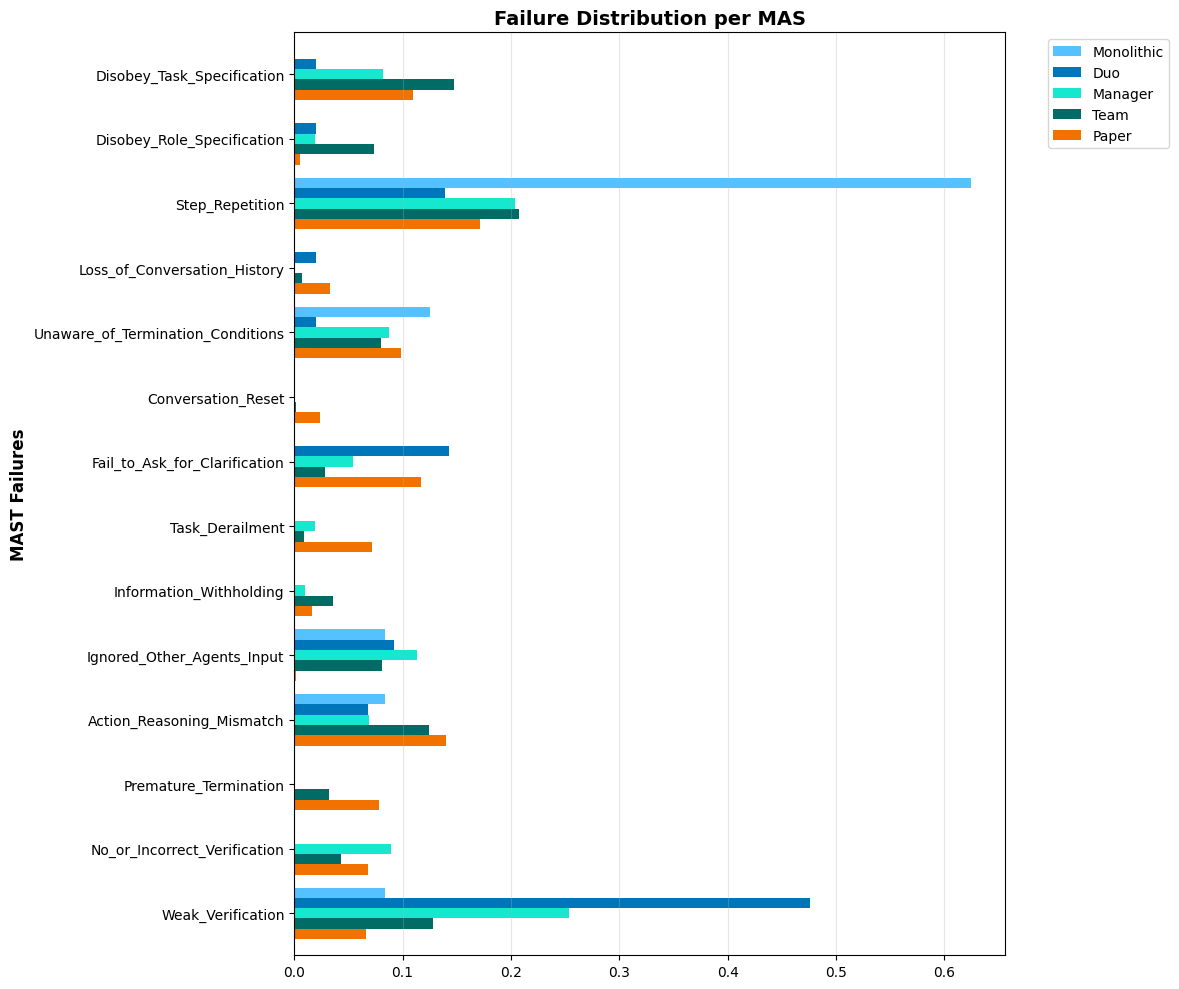

In [22]:
ax = failures[["Monolithic", "Duo", "Manager", "Team", "Paper"]].plot(
    kind="barh",
    figsize=(12, 10),
    width=0.8,
    color=["#56C1FF", "#0076BA", "#16E7CF", "#006C65", "#F27200"],
)

plt.title("Failure Distribution per MAS", fontsize=14, fontweight="bold")
plt.ylabel("MAST Failures", fontsize=12, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="x", alpha=0.3)
ax.invert_yaxis()
plt.tight_layout()
plt.show()